# Environment

In [1]:
import os
import cv2
import random

from PIL import Image
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt


from pathlib import Path
# from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torchvision import transforms
from torchvision.transforms import functional as TF
from torchvision.transforms import ToTensor, Grayscale, Resize

from torch.utils.data import Dataset, DataLoader    

from efficientnet_pytorch import EfficientNet

C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: ''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [142]:
# Path to the data directory
data_dir = Path("data_v1/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))


print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  113062
Number of labels found:  113062
Number of unique characters:  60
Characters present:  ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [4]:
# Desired image dimensions
img_width = 200
img_height = 50

# Preprocessing

In [7]:
# Mapping characters to integers
char_to_num = nn.Embedding(len(characters), 1)
# Mapping integers back to original characters
num_to_char = nn.EmbeddingBag(len(characters), 1)

In [8]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

def encode_single_sample(img_path, label):
    img = Image.open(img_path).convert("RGB")
    img = np.array(img) / 255.0
    img = cv2.resize(img, (img_width, img_height))
    img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
    
    char_to_idx = {char: idx for idx, char in enumerate(characters)}
    label = [char_to_idx[char] for char in label]
    label = torch.tensor(label, dtype=torch.long)
    
    return {"image": img, "label": label}

In [9]:
# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

# Visualize 

In [10]:
def decode_label(label):
    decoded_label = ""
    for char in label:
        if char in characters:
            decoded_label += char
    return decoded_label

<Figure size 800x1200 with 0 Axes>

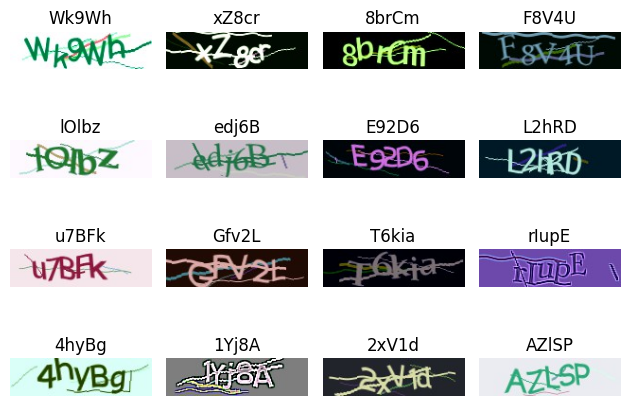

In [11]:
# Đặt kích thước của cửa sổ output
plt.figure(figsize=(8, 12))  # Điều chỉnh kích thước cửa sổ theo mong muốn

# Lấy các chỉ số ngẫu nhiên
random_indices = random.sample(range(len(images)), 16)

# Lấy các ảnh và nhãn ngẫu nhiên
random_images = [images[i] for i in random_indices]
random_labels = [labels[i] for i in random_indices]

# Giải mã các nhãn
decoded_labels = [decode_label(label) for label in random_labels]

# Tạo lưới subplot
num_rows = 4
num_cols = len(random_images) // num_rows
fig, axes = plt.subplots(num_rows, num_cols)

# Hiển thị ảnh và nhãn trong các subplot
for i, (image, label, decoded_label) in enumerate(zip(random_images, random_labels, decoded_labels)):
    ax = axes[i // num_cols, i % num_cols]
    image_data = plt.imread(image)
    ax.imshow(image_data, cmap='gray')
    ax.set_title(decoded_label)
    ax.axis('off')

# Điều chỉnh khoảng cách giữa các subplot
plt.tight_layout()

# Hiển thị đồ thị
plt.show()


# Create Dataset objects

In [12]:
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = self.images[index]
        label = self.labels[index]
        sample = encode_single_sample(img_path, label)
        return sample

In [13]:
# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])
max_length

5

In [14]:
train_dataset = CustomDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

validation_dataset = CustomDataset(x_valid, y_valid)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

In [15]:
train_loader_iter = iter(train_loader)
batch = next(train_loader_iter)
images, labels = batch['image'], batch['label']
print("Kích thước ảnh:", images.size())
print("Kích thước nhãn:", labels.size())

Kích thước ảnh: torch.Size([64, 3, 50, 200])
Kích thước nhãn: torch.Size([64, 5])


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Model

## Feature Extracting with EfficientNet_B0

In [14]:
model = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [ ]:
# model.eval()
model.to(device)


In [16]:

# Tạo một file để lưu đặc trưng
output_file = 'features_2.npy'

# Trích xuất đặc trưng và lưu vào file
all_features = []
total_batches = len(train_loader)
for batch_idx, sample in enumerate(tqdm(train_loader, total=total_batches)):
    images = sample['image']
    # Chuyển dữ liệu (images và labels) lên GPU
    images = images.to(device)

    with torch.no_grad():
        features = model.extract_features(images)
    
    # Xử lý đặc trưng trích xuất nếu cần
    flattened_features = features.view(features.size(0), -1)

    # Thêm đặc trưng vào danh sách tất cả các đặc trưng
    all_features.append(flattened_features.cpu().numpy())

# Gộp tất cả các đặc trưng thành một mảng numpy
all_features = np.concatenate(all_features, axis=0)

# Lưu đặc trưng vào file
np.save(output_file, all_features)

print("Trích xuất đặc trưng và lưu vào file thành công!")

100%|██████████| 1590/1590 [05:16<00:00,  5.02it/s]


Trích xuất đặc trưng và lưu vào file thành công!


## RNN & CTC

### DATA

In [2]:
# Đọc file features.npy
features = np.load('features.npy')

# Kiểm tra kích thước và cấu trúc của đặc trưng
print("Kích thước của đặc trưng:", features.shape)
print("Số lượng mẫu:", len(features))

# Kiểm tra kích thước đặc trưng cho mỗi mẫu (đây sẽ là chiều thứ 2 của features)
sample_feature_size = features.shape[1]
print("Kích thước đặc trưng cho mỗi mẫu:", sample_feature_size)

Kích thước của đặc trưng: (101755, 7680)
Số lượng mẫu: 101755
Kích thước đặc trưng cho mỗi mẫu: 7680


### Model

In [162]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.decoder = CTCDecoder(num_classes)  # Sử dụng đối tượng CTCDecoder như một thành phần của LSTMModel
        self.hidden_size = hidden_size
        self.num_layers = 1  # Số lớp LSTM
        self.num_directions = 1  # Hướng LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=self.num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, input_lengths):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(x.device)
        x = x.unsqueeze(1)  # Thêm một chiều tại vị trí thứ 2
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        
        # Thay đổi input_lengths thành None(bỏ giới hạn đầu ra)
        input_lengths = None
        
        return out, input_lengths


class CTCDecoder:
    def __init__(self, num_classes):
        self.num_classes = num_classes
    
    def to(self, device):
        # Chuyển lớp CTCDecoder sang thiết bị được chỉ định
        self.device = device
        return self
    
    def ctc_loss(self, logits, targets, input_lengths, target_lengths):
        ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True, reduction='mean')
        input_lengths = input_lengths.to(torch.int32)
        target_lengths = target_lengths.to(torch.int32)

        loss = ctc_loss(logits, targets, input_lengths, target_lengths)
        return loss

    def decode(self, logits, input_lengths):
        logits = logits.transpose(0, 1)  # Chuyển vị đầu ra từ LSTM
        input_lengths = input_lengths.to(torch.int32)

        _, decoded = torch.nn.functional.ctc_decode(logits, input_lengths, greedy=True)
        decoded = decoded[0]

        # Giải mã thành chuỗi ký tự
        decoded_str = ""
        for i in range(decoded.shape[0]):
            if decoded[i] != 0 and (not (i > 0 and decoded[i - 1] == decoded[i])):
                decoded_str += chr(decoded[i] + ord('a') - 1)  # Mã hóa từ chỉ mục sang ký tự

        return decoded_str


### Training

In [93]:
# Các tham số huấn luyện
num_epochs = 10
batch_size = 64
total_steps = len(features) // batch_size
learning_rate = 0.01

input_size = 7680
hidden_size = 128
num_classes = len(characters)

In [138]:
# Khởi tạo mô hình LSTM
lstm_model = LSTMModel(input_size, hidden_size, num_classes).to(device)
ctc_decoder = CTCDecoder(num_classes)

# Chuyển mô hình và decoder sang thiết bị GPU (nếu có)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model.to(device)
ctc_decoder.to(device)

# Tạo optimizer với các tham số của mô hình LSTM và decoder
optimizer = optim.Adam(
    list(lstm_model.parameters()),
    lr=learning_rate
)

In [ ]:
for batch_idx, sample in enumerate(tqdm(train_loader, total=len(train_loader))):
    labels_batch = sample['label']


In [165]:
labels_batch.shape

torch.Size([64, 5])

In [160]:
total_steps = round(len(features) / batch_size)
for epoch in range(num_epochs):
    # for i in range(0, len(features), batch_size):
    for i, sample in enumerate(tqdm(train_loader, total=len(train_loader))): 

        # Lấy batch hiện tại
        batch_features = features[i:i+batch_size]
        batch_labels = sample['label']

        # Chuyển batch sang thiết bị GPU (nếu có)
        batch_features = torch.from_numpy(batch_features).to(device)
        batch_labels = batch_labels.to(device)


        # Tính kích thước thực tế của mỗi nhãn
        target_lengths = torch.tensor([len(batch_labels)], dtype=torch.int32)
        input_lengths = torch.tensor([batch_features.size(0)], dtype=torch.int32)

        # Forward pass
        logits, _ = lstm_model(batch_features, input_lengths)

        # Tính toán loss dựa trên CTC
        loss = ctc_decoder.ctc_loss(logits, batch_labels, input_lengths, target_lengths)

        # Backward pass và cập nhật trọng số
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # In thông tin huấn luyện
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item()}")


  0%|          | 0/1590 [00:00<?, ?it/s]


RuntimeError: Expected tensor to have size 1 at dimension 0, but got size 64 for argument #2 'targets' (while checking arguments for ctc_loss_gpu)

In [104]:
len(batch_features)

64

In [ ]:
# Đánh giá mô hình sau khi huấn luyện
with torch.no_grad():
    # Lấy một ví dụ từ dữ liệu đầu vào
    example = features[0:1].to(device)
    
    # Forward pass
    logits, input_lengths = lstm_model(example, example.size(1))
    
    # Giải mã đầu ra
    decoded_str = ctc_decoder.decode(logits, input_lengths)
    
    print(f"Decoded string: {decoded_str}")

In [60]:
# # Huấn luyện mô hình
# for epoch in range(num_epochs):
#     epoch_loss = 0.0
    
#     # Sử dụng tqdm để theo dõi tiến trình huấn luyện
#     with tqdm(total=total_steps, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
#         for step in range(total_steps):
#             # Lấy batch hiện tại
#             batch_start_idx = step * batch_size
#             batch_end_idx = batch_start_idx + batch_size

#             batch_features = torch.tensor(features[batch_start_idx:batch_end_idx], dtype=torch.float32).to(device)
#             batch_labels = torch.tensor(int_labels[batch_start_idx:batch_end_idx], dtype=torch.long).to(device)

#             # Tính toán đầu ra và loss
#             outputs = model(batch_features)
#             log_probs = F.log_softmax(outputs, dim=1)
#             predicted_labels = torch.argmax(outputs, dim=1)
            
#             loss = F.nll_loss(log_probs, predicted_labels, reduction='mean')
#             epoch_loss += loss.item()
            
#             # Cập nhật gradients và thực hiện tối ưu hóa
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
            
#             # Cập nhật tiến trình tqdm
#             pbar.update(1)
#             pbar.set_postfix({'Loss': loss.item()})
    
#     # Hiển thị loss của epoch hiện tại
#     epoch_loss = float(epoch_loss) / total_steps
#     print(f'Epoch {epoch+1} - Average Loss: {epoch_loss:.4f}')

Epoch 1/10: 100%|██████████| 1589/1589 [00:21<00:00, 75.52batch/s, Loss=0.00048] 


Epoch 1 - Average Loss: 0.0649


Epoch 2/10: 100%|██████████| 1589/1589 [00:18<00:00, 87.90batch/s, Loss=9.75e-5] 


Epoch 2 - Average Loss: 0.0002


Epoch 3/10: 100%|██████████| 1589/1589 [00:18<00:00, 84.96batch/s, Loss=3.67e-5] 


Epoch 3 - Average Loss: 0.0000


Epoch 4/10: 100%|██████████| 1589/1589 [00:16<00:00, 94.12batch/s, Loss=1.57e-5] 


Epoch 4 - Average Loss: 0.0000


Epoch 5/10: 100%|██████████| 1589/1589 [00:17<00:00, 92.18batch/s, Loss=6.79e-6] 


Epoch 5 - Average Loss: 0.0000


Epoch 6/10: 100%|██████████| 1589/1589 [00:16<00:00, 93.89batch/s, Loss=2.74e-6] 


Epoch 6 - Average Loss: 0.0000


Epoch 7/10: 100%|██████████| 1589/1589 [00:19<00:00, 83.36batch/s, Loss=1.15e-6] 


Epoch 7 - Average Loss: 0.0000


Epoch 8/10: 100%|██████████| 1589/1589 [00:19<00:00, 80.43batch/s, Loss=4.88e-7] 


Epoch 8 - Average Loss: 0.0000


Epoch 9/10: 100%|██████████| 1589/1589 [00:16<00:00, 95.81batch/s, Loss=1.99e-7] 


Epoch 9 - Average Loss: 0.0000


Epoch 10/10: 100%|██████████| 1589/1589 [00:17<00:00, 88.91batch/s, Loss=8.2e-8] 

Epoch 10 - Average Loss: 0.0000


In [64]:
# Lưu mô hình vào tệp
torch.save(model.state_dict(), 'LSTM.pth')

# # Tải mô hình từ tệp
# model = YourModelClass()  # Tạo mô hình mới
# model.load_state_dict(torch.load('path_to_save_model.pth'))